# Continuous variation of height

In [4]:
import sys
import os
sys.path.insert(0, './magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloid as mgc
import matplotlib as mpl
import string as st

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In this notebook we will attemt to run a long simulation in which we vary the height as a linear function of time. We'll start with an ordered dimer configuration (which is now in the standard magcolloids package). 

To define a simulation in which walls are shrinking I override the `create_wall_string` function in the magcolloids package (recently created) and introduce a couple of new variables that represent the position of each wall. 

In [14]:
rho = 1.4 * ureg.um
h0 = 3.9*(rho)
hf = 2.1*(rho)
dt = 360*ureg.s
slope = (hf-h0)/dt

class shrinking_world(mgc.world):
    def create_wall_string(self):
        
        walls = st.Template("""
variable semiheight1 equal -($h0+($slope*time))/2
variable semiheight2 equal ($h0+($slope*time))/2

fix 	3 Atoms wall/lj126 zlo v_semiheight1 $lj_eps $lj_sgm  $lj_cut zhi v_semiheight2 $lj_eps $lj_sgm  $lj_cut """)

        return walls.substitute(
                    h0=h0.to(ureg.um).magnitude,
                    slope=slope.to(ureg.um/ureg.us).magnitude,
                    lj_eps=self.lj_parameters[0].magnitude,
                    lj_sgm=((self.particles[0].radius)*self.lj_parameters[1]).magnitude,
                    lj_cut=((self.particles[0].radius)*self.lj_cutoff).magnitude,
                    )

With this modification to the lammps scripts, the height (total height, wall to wall) is given by
$$h = h_0+vt$$
where $v = \frac{\left(h_f-h_0\right)}{\Delta t}$

In these tests we are going from close to $h_0 = 4\rho$ (where dimers are almost upright) to $h_f = 2\rho$ where all particles are in a single plane (and dimers are impossible). Also, for the first tests, the whole compression process is realized on a period of $\Delta t=6 min$ 

In [15]:
t = np.linspace(0,6,100)*ureg.min

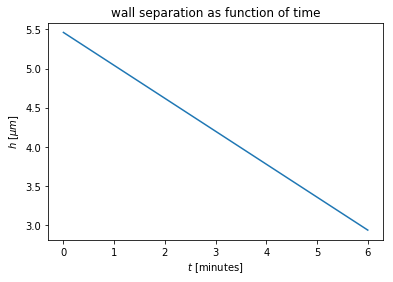

In [24]:
plt.plot(t,h0 + (t*slope))
plt.xlabel("$t$ [minutes]")
plt.ylabel("$h$ [$\mu{}m$]")
plt.title("wall separation as function of time");

## Simulation of 6 minutes compression, T = 300K, with multibody induced dipole. 

In [3]:
region, positions = mgc.ordered_dimers(n_of_particles = 150, packing=0.4, height = h0.magnitude, r = rho.magnitude, theta = 0)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [5]:
field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees,multibody_iter=2)

world = shrinking_world(particles, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

In [6]:
sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",file_name="h_variation",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = dt,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [7]:
sim.load()
trj = sim.lazy_read[::10]

In [8]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

Video is sped up $\times 10$

## Simulation of 6 minutes compression, T = 1K, with multibody induced dipole.

To see with more clarity where the ferromagnetic order breaks, we run a simulation with a very low temperature

In [6]:
field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees,multibody_iter=2)
world = shrinking_world(particles, temperature = 1*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",file_name="h_variation",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = t,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [7]:
sim.load()
trj = sim.lazy_read[::10]

In [8]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

Video is sped up $\times 10$

This means that the breaking of the ferromagnetic order is given by the dipolar interaction, and is not entropic. Running the video slowly we see that the ferromagnetic order appears at around 4 seconds, it breaks at about 17 seconds and the dimer phase breaks at 21 seconds. Since the video speed is $\times 10$ real speed, this corresponds to a height of $5.18\mu{m}$, $4.21\mu{m}$ and $3.99\mu{m}$ respectively.

In [17]:
h0+slope*([40e6,170e6,210e6]*ureg.us)

<Quantity([ 5.18  4.27  3.99], 'micrometer')>

## Simulation of 6 minutes compression, T = 1K, with *no* multibody induced dipole.

At the end of notebook 29 we see that the onset and breaking points of the ferromagnetic order appear at very close values of the *inplane* value of the magnetic moment. This inplane value is completely due to the multibody induced dipole. It is therefore concievable that the ferromagnetic order arises from this inplane dipole moment. **However** when we run simulations with *no* induced dipole moment (that is, all dipoles are parallel to external field, ${\bf B}\equiv B{\bf \hat{e}_z}$) the ferromagnetic state *still* occurs (see below). 

<img src=InducedMomentInPlane.png>

In [6]:
field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees,multibody_iter=0)
world = shrinking_world(particles, temperature = 1*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",file_name="h_variation",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = t,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [7]:
sim.load()
trj = sim.lazy_read[::10]

In [8]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=360,step=10,speedup=10))

Video is sped up $\times 10$

Even more confusingly, it appears to be stable for more time *without* induced dipole moment.

## Simulation of 60 minutes compression, T = 1K, with multibody induced dipole.

To ensure that we are seeing equilibrated states we run the same compression protocol but over a $\Delta t = 60 min$ interval. 

In [6]:
rho = 1.4 * ureg.um
h0 = 3.9*(rho)
hf = 2.1*(rho)
t = 3600*ureg.s
slope = (hf-h0)/t

class shrinking_world(mgc.world):
    def create_wall_string(self):
        
        walls = st.Template("""
variable semiheight1 equal -($h0+($slope*time))/2
variable semiheight2 equal ($h0+($slope*time))/2

fix 	3 Atoms wall/lj126 zlo v_semiheight1 $lj_eps $lj_sgm  $lj_cut zhi v_semiheight2 $lj_eps $lj_sgm  $lj_cut """)

        return walls.substitute(
                    h0=h0.to(ureg.um).magnitude,
                    slope=slope.to(ureg.um/ureg.us).magnitude,
                    lj_eps=self.lj_parameters[0].magnitude,
                    lj_sgm=((self.particles[0].radius)*self.lj_parameters[1]).magnitude,
                    lj_cut=((self.particles[0].radius)*self.lj_cutoff).magnitude,
                    )

In [7]:
region, positions = mgc.ordered_dimers(n_of_particles = 150, packing=0.4, height = h0.magnitude, r = rho.magnitude, theta = 0)

particles = mgc.particles(
    positions*ureg.um,
    radius = 1.4*ureg.um,
    susceptibility = 0.4,
    diffusion=0.073*ureg.um**2/ureg.s,
    density = 1000*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [8]:
field = mgc.field(magnitude = 7.28*ureg.mT, frequency = 0*ureg.Hz, angle = 0*ureg.degrees,multibody_iter=2)
world = shrinking_world(particles, temperature = 1*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 30*ureg.um)

sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",file_name="h_variation",stamp_time=True,
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = t,
       particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

sim.generate_scripts()
sim.run()

In [9]:
sim.load()
trj = sim.lazy_read[::10]

In [12]:
HTML(mgc.display_animation_direct(sim,trj,start=0,end=3600,step=50,speedup=60))

Video is sped up $\times 60$

It appears that all the phenomena which was present in the previous case appears also in this case *except* for the initial disordered state. The ferromagnetic state seems to be stable for all the larger separations. 